<a href="https://colab.research.google.com/github/talegaman/Project-Week-1-Build-Your-Own-Game/blob/master/spaceag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Space AG Data Analyst Challenge
SpaceAG es una empresa que da herramientas para ayudar al agricultor a tomar mejores decisiones. Dentro de las herramientas usadas están los datos adquiridos de las imágenes de satélite, entre ellos el NDVI.

## NDVI
El NDVI es un índice de vegetación que mide el vigor de las plantas, es decir, una medición indirecta de la salud de la planta. Los valores de este índice van de -1 a 1. A mayor valor de NDVI en un determinado pixel de la imagen entonces se espera una mayor biomasa del cultivo, es decir un cultivo más sano. A menores valores de NDVI se espera una menor biomasa o un área de vegetación o cultivo enferma. Asimismo, los valores de vegetación están entre 0.2 a 1 de NDVI. Así también, el suelo generalmente tienen valores negativos de NDVI hasta valores de 0.2 en este índice. Como información adicional, la presencia de nubes sobre el área evaluar afecta el promedio del NDVI.

Algunos agricultores de paltos piensan que puede existir una relación entre el NDVI con el rendimiento (Kg/Ha) del cultivo.

NDVI = (BAND 8 - BAND 4) / (BAND 8 + BAND 4)

# El desafío
## En este reto vamos a explorar el ndvi de un campo. Estos son los objetivos a lograr: 

1.-Extraer las bandas de satélite de Sentinel 2 usando Sentinel Hub para la lista de fechas disponibles que te brindamos en SentinelHubImage-available_dates.xlsx.

In [520]:
# Instalacion de librerías

# !pip install geos
# !pip install Shapely
 !pip install sentinelhub

In [0]:
#Celda de importaciones.
from matplotlib import  cm
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, SHConfig, \
FisRequest,Geometry,WcsRequest, CustomUrlParam, DataSource, HistogramType, \
BBoxCollection, data_request

from sentinelhub.time_utils import iso_to_datetime
from shapely.geometry import Polygon
import pandas, datetime, json, seaborn, os
import numpy as np
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline


#Sentinel FIS (Feature Info System)


In [0]:
# Conexión con el sitio mediante la id_instance para uso de la librería
# sentinelhub.

# In case you put instance ID into config file you can leave this unchanged
INSTANCE_ID = "71946db8-dfd6-4a0b-848f-839f6388b6e9"  

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

In [0]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

In [524]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Lectura de datos para extracción.
with open('/content/drive/My Drive/material ironhack/space-ag-data-analyst-challenge/farm_map.json') as f:
  data_json = json.load(f) # dict_keys(['crs', 'setup', 'type', 'features'])

data_excel = pandas.read_excel('/content/drive/My Drive/material ironhack/space-ag-data-analyst-challenge/SentinelHubImage-available_dates.xlsx')       

In [526]:
#JSON FILE
print('CRS: ',data_json['crs'])
print('SETUP: ', data_json['setup'])
print('TYPE: ', data_json['type'])
print('FEATURES: ', data_json['features'])
print('------------------------------------------------------')
print('FEATURE_LEN: ', len(data_json['features']),'registros')
print('------------------------------------------------------')
print('FEATURE_Registro_keys: ', data_json['features'][0].keys())

CRS:  {'type': 'name', 'properties': {'name': 'EPSG:4326'}}
SETUP:  {'variable': {'id': 551, 'name': 'Rendimiento', 'category': 'Production', 'requires_time': False, 'project': 243, 'cartography': 747, 'measurement_unit': 'Kg/Ha'}, 'cartography': {'id': 747, 'name': 'Cartografía de lote', 'unit_name': 'lote'}, 'measurement_unit': 'Kg/Ha', 'legend': [], 'data_type': 'float', 'real_setup': False, 'inverted_legend': False, 'display_total_in_dashboard': False, 'variable_group': None}
TYPE:  FeatureCollection
FEATURES:  [{'geometry': {'type': 'Polygon', 'coordinates': [[[-75.6396578867764, -14.199701335951724], [-75.64231663022875, -14.20062882414364], [-75.64298408105815, -14.198802571721302], [-75.64032613621433, -14.197876401443217], [-75.6396578867764, -14.199701335951724]]]}, 'type': 'Feature', 'properties': {'values': [{'value': 3581.158766439885, 'variety': {}, 'measurement_unit': 'Kg/Ha', 'date_stamp': '2019-09-19', 'metadata': None, 'time_stamp': None}], 'unit': {'state': {'area': 

In [527]:
# EXCEL FILE

# La información que muestra es de las GRANJA, ID, FECHA y FECHA/HORA en las
# que fueron validadas. De primera idea aqui tengo que completar
# el dataset para su analisis.


#Renombrar columnas, y analizando datetime si debe transformarse o se dropea.
data_excel = data_excel.rename(columns={'_date':'date','_datetime_utc':'datetime'}).sort_values(by='id') 
data_excel

,id,farm,date,datetime,validated
12,8230,163,2019-10-23,2019-10-23 15:26:59,1
13,8232,163,2019-10-13,2019-10-13 15:26:59,1
14,8233,163,2019-10-08,2019-10-08 15:27:00,1
15,8234,163,2019-10-03,2019-10-03 15:26:58,1
16,8235,163,2019-09-28,2019-09-28 15:26:59,1
...,...,...,...,...,...
4,10946,163,2020-02-10,2020-02-10 15:26:52,1
3,11202,163,2020-02-15,2020-02-15 15:26:51,1
2,11899,163,2020-03-11,2020-03-11 15:26:55,1
1,13892,163,2020-04-15,2020-04-15 15:26:57,1


In [528]:
data_excel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 12 to 0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         89 non-null     int64 
 1   farm       89 non-null     int64 
 2   date       89 non-null     object
 3   datetime   89 non-null     object
 4   validated  89 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 4.2+ KB


In [529]:
# Hasta este punto tengo los datos conectados y listos para extraer y acomodar.
# Poligon es el area del terreno del sembradío, se requiere obtener su
# posición gps para obtener en Sentinel esa posición, en las fechas que tienen
# marcadas el excel.
# En el ejemplo para la obteción de imagenes en Sentinel, mencionan que se debe
# usar una instancia de BBOX, para obtener dicha imagen y en el objeto 
# controlar los parametros

# coordinate reference system (CRS) 

crs747 = data_json['crs']['properties']['name'] # EPSG:4326

# Lista de lista de coordenandas.
coords747 = data_json['features'][0]['geometry']['coordinates'][0]#[:-1] 

#Se reduce la lista para que funcione como en el ejemplo.
coords_flat_list = [item for lista in coords747 for item in lista]
round_coords = [round(num,4) for num in coords_flat_list] # round 2 decimales

coords_flat_1 = round_coords[:4] #mitad 1
coords_flat_2 = round_coords[4:8] #mitad 2

#print(betsiboka_coords_wgs84, 'ejemplo') #Ejemplo
print(round_coords)
print(coords_flat_1)
print(coords_flat_2)
coords_flat_list

[-75.6397, -14.1997, -75.6423, -14.2006, -75.643, -14.1988, -75.6403, -14.1979, -75.6397, -14.1997]
[-75.6397, -14.1997, -75.6423, -14.2006]
[-75.643, -14.1988, -75.6403, -14.1979]


[-75.6396578867764,
 -14.199701335951724,
 -75.64231663022875,
 -14.20062882414364,
 -75.64298408105815,
 -14.198802571721302,
 -75.64032613621433,
 -14.197876401443217,
 -75.6396578867764,
 -14.199701335951724]

In [530]:
data = data_excel.sort_values(by='date').copy()
list_dates = list(data.date)
fecha_inicio = list_dates[0]
fecha_fin = list_dates[-1]

print('Fecha Inicio: ',fecha_inicio,' ','Fecha Fin: ', fecha_fin)

Fecha Inicio:  2016-07-15   Fecha Fin:  2020-04-20


In [0]:
betsiboka_coords_wgs84 = [46.16, -16.15, 46.51, -15.58] # coords/celda de ejemplos y pruebas
bbox_carto747 = BBox(bbox = betsiboka_coords_wgs84, crs=CRS.WGS84) # bbox Funcional

#Bboxes de las 2 partes para mostrarlas
bbox_spaceag = BBox(bbox = coords_flat_1, crs=CRS.WGS84)
bbox_spaceag1 = BBox(bbox = coords_flat_2, crs=CRS.WGS84)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (856, 512)
----------------------------
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (856, 512)


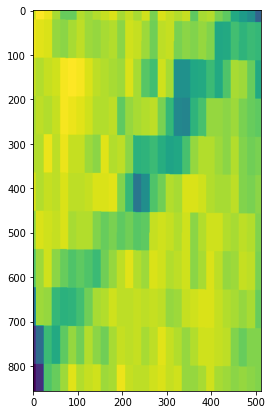

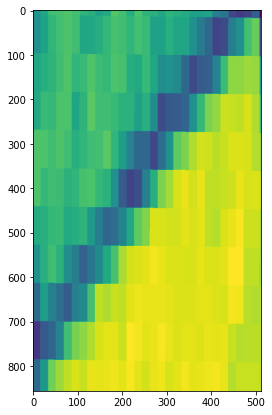

In [532]:
# A partir de aquí se pueden realizar los requests con WMS (Web Map Service).
wms_true_color_request = WmsRequest(layer='NDVI', bbox= bbox_spaceag, time ='latest', width=512, height=856, config=config,)
wms_true_color_request1 = WmsRequest(layer='NDVI', bbox= bbox_spaceag1, time ='latest', width=512, height=856, config=config)

wms_img = wms_true_color_request.get_data()
wms_img1 = wms_true_color_request1.get_data()

print('Returned data is of type = %s and length %d.' % (type(wms_img), len(wms_img)))
print('Single element in the list is of type {} and has shape {}'.format(type(wms_img[-1]), wms_img[-1].shape))

plot_image(wms_img[-1])
plot_image(wms_img1[-1])

print('----------------------------')
print('Returned data is of type = %s and length %d.' % (type(wms_img1), len(wms_img1)))
print('Single element in the list is of type {} and has shape {}'.format(type(wms_img1[-1]), wms_img1[-1].shape))

#plot_image(wms_img1[-1])

<class 'list'> 33


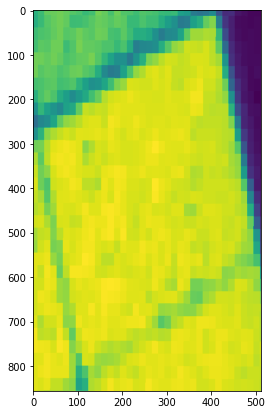

In [533]:
# Geometry permite crear un bbox apartir de un poligono dado. EL JSON.
# Chulada de descubrimiento porque no hay ejemplos casi en internet.
print(type(data_json['features']),len(data_json['features'][:]))

data_json_geometry = data_json['features'][:][0]['geometry'] #Lote 1 pos0
bbox_temp = Geometry(geometry=data_json_geometry, crs=CRS.WGS84)

wms_true_color_request_pol = WmsRequest(layer='NDVI', bbox= bbox_temp.bbox, time ='latest', width=512, height=856, config=config)
wms_img_pol = wms_true_color_request_pol.get_data()
plot_image(wms_img_pol[-1])

In [534]:
# Crear una lista de BBOX -bboxlist
# Este ejemplo no lo tiene ni Obama.

def create_bboxlist(features_list):
  lista_bboxes = []
  for x in features_list:
    x = Geometry(geometry=x['geometry'], crs=CRS.WGS84).bbox
    lista_bboxes.append(x)
  return BBoxCollection(lista_bboxes)

bboxes = create_bboxlist(data_json['features'])
print(type(bboxes))

<class 'sentinelhub.geometry.BBoxCollection'>


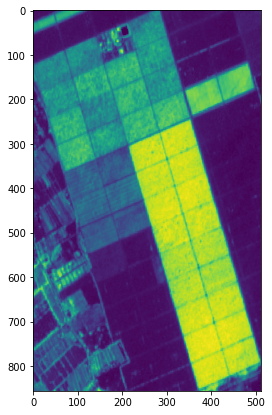

In [535]:
# Imprimir la coleccion de bboxes
# FUNCIONAL
wms_true_color_request_pol = WmsRequest(layer='NDVI', bbox= bboxes.bbox, time ='latest', width=512, height=856, config=config)
wms_img_pol = wms_true_color_request_pol.get_data()
plot_image(wms_img_pol[-1])

In [0]:
# Hay un parametro de Sentinel para obtener todas las imagenes del mismo punto
# en un rango de fechas dadas en el parametro 'time'=('YYY-MM-DD', 'YYY-MM-DD')
# dentro de BBox
#%%

wms_true_color_request = WmsRequest(
    layer='TRUE-COLOR-S2-L1C',
    bbox=bboxes.bbox,
    time=(fecha_inicio, fecha_fin),
    width=512,
    height=856,
    data_folder='./data',
    config=config
)

wms_true_color_img = wms_true_color_request.get_data(save_data=True)

In [537]:
print('There are %d Sentinel-2 images available' % len(wms_true_color_img))
wms_true_color_request.save_data()

There are 204 Sentinel-2 images available


In [538]:
os.listdir(wms_true_color_request.data_folder) # Todas las imagenes guardadas

['9f06c3bf9ce09432c1dd2d2eec5555a7',
 '78891e65dcf1a2221cc466d56ee9494e',
 'ede27bcd08c3cb698c7307e2b21db6cf',
 '7c99f4738715da45003a209e662f8403',
 '9b5f275ccdcd5479dad6056553300f28',
 '0aa32d924b36bfdec91902662ba4c47c',
 'de177cf3406113b879bd3721fe8f6b2d',
 '6d1f788379bcc9dbf1ccd3293a2f5537',
 'deb5f75a0daea59e5eee0364c0cbf4a7',
 'b3d487672bb9d677e7f9c974ce9f523f',
 '8ccc2f992c48631d61353027b6e3ef27',
 'ffe04e914b99bbc54febe5a11840e500',
 '038f77656b6108809b1a51f000398f67',
 'f4a1b512dcc39c848abdb1ad27365458',
 '1b6f9dfdf2ebe02340b308c25b4cdb50',
 '7d45c84148a93590bbe0cf3611b9bd01',
 '839eb4fc57f38f620f406f7ff1b2a9c6',
 '577b6446e68844511aea7bae0b68df6b',
 '58dc2c5374d80d78822a9f44bc3f7918',
 '202015f85286e868967b527db5f1a832',
 'fa471ee70715459e7c370e574acc14f7',
 '0e886b0cec038b8fe2d3b0339ad6283a',
 'e7366e608e526ae9a027f5d4d9b85586',
 '1b1fe1037b4dba3e9920f6829b0641f7',
 '121a28b0a9ea7f40114be7978dd74277',
 'cafde85cab8d1535f657b4d024af0544',
 '5f23fc6579088b56d8f8984b291fc0e7',
 

In [0]:
##Ya imprimi todas las fotos de farm_map en el rango
#de fechas pedido, en total son 204 imagenes

2.-Extraer los valores de NDVI promedio para cada lote para cada una de las fechas. Cada lote es un feature del geojson adjunto en el repositorio.

In [0]:
# Se puede obtener información estadistica con FIS (Feature Information Service)
# Necesitamos obtener los valores de NDVI de los lotes y obtener promedio
# Obtener ese mismo promedio en cada fecha solicitada
#%%
fis_request = FisRequest(layer='BANDS-S2-L1C',
    geometry_list=bboxes,
    time=(fecha_inicio, fecha_fin),
    resolution='60m',
    data_folder='./data',
    config=config)

fis_data = fis_request.get_data(save_data=True)

In [541]:
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    """
    COLUMNS = ['channel', 'date', 'min', 'max', 'mean', 'stDev']
    data = []

    for fis_response in fis_data:
        for channel, channel_stats in fis_response.items():
            for stat in channel_stats:
                row = [int(channel[1:]), iso_to_datetime(stat['date'])]

                for column in COLUMNS[2:]:
                    row.append(stat['basicStats'][column])

                data.append(row)

    return pandas.DataFrame(data, columns=COLUMNS).sort_values(['channel', 'date'])


df = fis_data_to_dataframe(fis_data)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87516 entries, 203 to 87312
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   channel  87516 non-null  int64         
 1   date     87516 non-null  datetime64[ns]
 2   min      87516 non-null  object        
 3   max      87516 non-null  object        
 4   mean     87516 non-null  object        
 5   stDev    87516 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 4.7+ MB


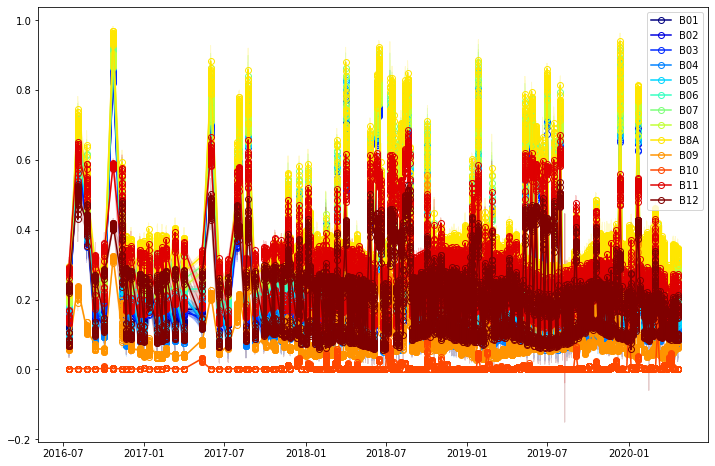

In [542]:
BANDS = 'B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12'.split(',')

for col in ['min','max','mean','stDev']:
  df[col] = df[col].astype('float')

plt.figure(figsize=(12, 8))
for channel, (band, color) in enumerate(zip(BANDS, cm.jet(np.linspace(0, 1, 13)))):
  channel_df = df[df.channel == channel]
  plt.plot(channel_df.date, channel_df['mean'], '-o', markeredgewidth=1, color=color, markerfacecolor='None', label=band)
  plt.fill_between(list(channel_df.date), channel_df['mean'] - channel_df['stDev'], channel_df['mean'] + channel_df['stDev'], alpha=0.2, color=color)

plt.legend(loc='upper right');

In [543]:
# Se puede obtener NDVI usando un request parecido a WMS.
#%%
ndvi_script = 'return [(B05 - B04) / (B05 + B04)]'

ndvi_request = FisRequest(
    layer='NDVI',
    geometry_list = bboxes,
    time=(fecha_inicio, fecha_fin),
    resolution='100m',
    bins=20,
    histogram_type=HistogramType.EQUIDISTANT,
    data_source=DataSource.SENTINEL2_L1C,
    custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_script},
    config=config,
    data_folder='./data'
)

ndvi_data = ndvi_request.get_data(save_data=True)

df_ndvi = fis_data_to_dataframe(ndvi_data)
df_ndvi

,channel,date,min,max,mean,stDev
203,0,2016-07-15,0.0172712,0.272103,0.165447,0.0994311
407,0,2016-07-15,0.0115517,0.288079,0.1666,0.094362
611,0,2016-07-15,0.0355921,0.270485,0.203501,0.0613557
815,0,2016-07-15,0.129788,0.249399,0.217073,0.0321959
1019,0,2016-07-15,0.0184157,0.240997,0.202454,0.0569181
...,...,...,...,...,...,...
5712,0,2020-04-20,0.0354074,0.0866637,0.0519993,0.0138124
5916,0,2020-04-20,0.0317812,0.0999225,0.0547502,0.0178939
6120,0,2020-04-20,0.03849,0.0944056,0.0718889,0.0162382
6324,0,2020-04-20,0.0331588,0.0916553,0.0534321,0.0151042


In [544]:
# Crear Dataframe de los valores del GeoJSON
#%%

df_json_features = pandas.json_normalize(data_json["features"]) #Dataframe 1

def normalize_column(column):
  df_temp = pandas.DataFrame(columns=('value','variety','measurement_unit','date_stamp','metadata','time_stamp'))
  for row in column:
    df_temp = df_temp.append(row)
    #print(row)
  return df_temp

prop_values = normalize_column(df_json_features['properties.values']) #DF2
type(prop_values)
df_json_features

,type,geometry.type,geometry.coordinates,properties.values,properties.unit.state.area,properties.unit.state.year_of_planting,properties.unit.state.variety,properties.unit.metadata,properties.unit.id,properties.unit.full_name,properties.unit.name
0,Feature,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...","[{'value': 3581.158766439885, 'variety': {}, '...",6.530601,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90214,lote AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36
1,Feature,Polygon,"[[[-75.64231663022875, -14.20062882414364], [-...","[{'value': 4037.3751791811173, 'variety': {}, ...",6.555069,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90215,lote AGRICOLA CHAPI.DON ERNESTO.PAL-1.37,AGRICOLA CHAPI.DON ERNESTO.PAL-1.37
2,Feature,Polygon,"[[[-75.63898926117189, -14.201527268326426], [...","[{'value': 4658.420440484501, 'variety': {}, '...",6.533254,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90216,lote AGRICOLA CHAPI.DON ERNESTO.PAL-1.42,AGRICOLA CHAPI.DON ERNESTO.PAL-1.42
3,Feature,Polygon,"[[[-75.64164955317383, -14.202454024468352], [...","[{'value': 4196.272165747293, 'variety': {}, '...",6.551013,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90217,lote AGRICOLA CHAPI.DON ERNESTO.PAL-1.43,AGRICOLA CHAPI.DON ERNESTO.PAL-1.43
4,Feature,Polygon,"[[[-75.64164955317383, -14.202454024468352], [...","[{'value': 4744.580970357842, 'variety': {}, '...",6.534646,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90218,lote AGRICOLA CHAPI.DON ERNESTO.PAL-1.48,AGRICOLA CHAPI.DON ERNESTO.PAL-1.48
5,Feature,Polygon,"[[[-75.64431888131925, -14.203383890611855], [...","[{'value': 4914.518933170159, 'variety': {}, '...",6.562506,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90219,lote AGRICOLA CHAPI.DON ERNESTO.PAL-1.49,AGRICOLA CHAPI.DON ERNESTO.PAL-1.49
6,Feature,Polygon,"[[[-75.63765710540375, -14.20516513033943], [-...","[{'value': 3081.5154889943, 'variety': {}, 'me...",6.498691,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90221,lote AGRICOLA CHAPI.DON ERNESTO.PAL-2.54,AGRICOLA CHAPI.DON ERNESTO.PAL-2.54
7,Feature,Polygon,"[[[-75.64031869971863, -14.206095306337506], [...","[{'value': 2970.0807760737507, 'variety': {}, ...",6.525776,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90222,lote AGRICOLA CHAPI.DON ERNESTO.PAL-2.55,AGRICOLA CHAPI.DON ERNESTO.PAL-2.55
8,Feature,Polygon,"[[[-75.64031869971863, -14.206095306337506], [...","[{'value': 4789.354613313465, 'variety': {}, '...",6.561207,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90224,lote AGRICOLA CHAPI.DON ERNESTO.PAL-3.60,AGRICOLA CHAPI.DON ERNESTO.PAL-3.60
9,Feature,Polygon,"[[[-75.64298986878343, -14.20702879053244], [-...","[{'value': 4222.732171703558, 'variety': {}, '...",6.569781,[2019],"[hass, fuerte, zutano]","[{'level_name': 'empresa', 'name': 'agricola c...",90225,lote AGRICOLA CHAPI.DON ERNESTO.PAL-3.61,AGRICOLA CHAPI.DON ERNESTO.PAL-3.61


In [545]:
#Concatener Dataframes
prop_values.reset_index()

df_raw = pandas.merge(df_json_features, prop_values, left_index=True, right_index=True)
df_raw.reset_index()
df_raw.keys()

Index(['type', 'geometry.type', 'geometry.coordinates', 'properties.values',
       'properties.unit.state.area', 'properties.unit.state.year_of_planting',
       'properties.unit.state.variety', 'properties.unit.metadata',
       'properties.unit.id', 'properties.unit.full_name',
       'properties.unit.name', 'value', 'variety', 'measurement_unit',
       'date_stamp', 'metadata', 'time_stamp'],
      dtype='object')

In [546]:
# Ya que tengo la información del promedio (mean) de las fechas disponibles en
# el poligono dado, solo queda juntar los Dataframes para tener solo la info
# requerida de inicio. Lo mas sano sería hacer un tipo merge por 'date'

data_excel['date'] = pandas.to_datetime(data_excel['date'])

#data_merge = data_excel.merge(df_ndvi, left_index=True, right_index=True)
data_merge = pandas.merge(data_excel,df_ndvi, how='left',on='date')
data_merge

,id,farm,date,datetime,validated,channel,min,max,mean,stDev
0,8230,163,2019-10-23,2019-10-23 15:26:59,1,0,0.0735108,0.242084,0.167868,0.0588226
1,8230,163,2019-10-23,2019-10-23 15:26:59,1,0,0.054593,0.239892,0.154211,0.0625969
2,8230,163,2019-10-23,2019-10-23 15:26:59,1,0,0.037458,0.264368,0.184986,0.0576512
3,8230,163,2019-10-23,2019-10-23 15:26:59,1,0,0.0521327,0.239892,0.185321,0.0519944
4,8230,163,2019-10-23,2019-10-23 15:26:59,1,0,0.0172144,0.240931,0.186257,0.05373
...,...,...,...,...,...,...,...,...,...,...
2932,14180,163,2020-04-20,2020-04-20 15:26:52,1,0,0.0354074,0.0866637,0.0519993,0.0138124
2933,14180,163,2020-04-20,2020-04-20 15:26:52,1,0,0.0317812,0.0999225,0.0547502,0.0178939
2934,14180,163,2020-04-20,2020-04-20 15:26:52,1,0,0.03849,0.0944056,0.0718889,0.0162382
2935,14180,163,2020-04-20,2020-04-20 15:26:52,1,0,0.0331588,0.0916553,0.0534321,0.0151042


In [0]:
# Limpieza de Dataframes utiles.
#df_raw
df_raw = df_raw[['geometry.type', 'geometry.coordinates',
       'properties.unit.state.area', 'properties.unit.state.year_of_planting',
       'properties.unit.state.variety',
       'properties.unit.id',
       'properties.unit.name', 'value', 'variety','date_stamp']]

In [548]:
df_raw.columns = ['geotype', 'coordinates',
       'area', 'year_of_planting',
       'variety',
       'id',
       'name', 'Kg/Ha', 'variety', 
       'date']
df_raw

,geotype,coordinates,area,year_of_planting,variety,id,name,Kg/Ha,variety,date
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,3581.158766,{},2019-09-19
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,4037.375179,{},2019-09-19
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,4658.420440,{},2019-09-19
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,4196.272166,{},2019-09-19
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,4744.580970,{},2019-09-19
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,4914.518933,{},2019-09-19
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,3081.515489,{},2019-09-19
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,2970.080776,{},2019-09-19
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,4789.354613,{},2019-09-19
0,Polygon,"[[[-75.6396578867764, -14.199701335951724], [-...",6.530601,[2019],"[hass, fuerte, zutano]",90214,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,4222.732172,{},2019-09-19


In [549]:
data_merge = data_merge[['id', 'date', 'datetime', 'mean']]
data_merge

,id,date,datetime,mean
0,8230,2019-10-23,2019-10-23 15:26:59,0.167868
1,8230,2019-10-23,2019-10-23 15:26:59,0.154211
2,8230,2019-10-23,2019-10-23 15:26:59,0.184986
3,8230,2019-10-23,2019-10-23 15:26:59,0.185321
4,8230,2019-10-23,2019-10-23 15:26:59,0.186257
...,...,...,...,...
2932,14180,2020-04-20,2020-04-20 15:26:52,0.0519993
2933,14180,2020-04-20,2020-04-20 15:26:52,0.0547502
2934,14180,2020-04-20,2020-04-20 15:26:52,0.0718889
2935,14180,2020-04-20,2020-04-20 15:26:52,0.0534321


3.- Guardar las imágenes de NDVI de cada lote y cada fecha.

In [0]:
#Realizado arriba cuando se guardaron las imagenes de todo el polígono.

4.- Hacer un análisis de los datos obtenidos para obtener insights de cómo el NDVI se comporta en el tiempo para los diferentes lotes.

In [551]:
#Voy a revisar la correlación que existe entre el NVDI y KG/Ha
#%%

data_merge.corr(df_raw.all)

,id
id,1.0
